# [Module 3.0] Batch Transform Inference
이 노트북에서는 아래와 같은 내용을 진행 합니다.
- Bactch Transform Job 실행
- Test 데이터의 결과 생성 (Churn의 유무를 True, False로 구분)
- Ground Truth 데이터와 비교 (Confustion Matrix)
- Evaluation Metrics 확인 (F1, Precision, Recall, Accuracy)

실행 시간은 약 5분 소요 됩니다.

In [1]:
%store -r

In [2]:
import boto3

from sagemaker.transformer import Transformer
import pandas as pd
import sagemaker

from time import strftime, gmtime

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
client = boto3.client('sagemaker')

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
transform_job_name = 'churn-batch-transform-' + timestamp_prefix

output_prefix = 'output'
output_path = 's3://{}/{}/{}'.format(bucket, prefix, output_prefix)

### Batch Transfomer 생성

In [3]:
# Make Transformer object
transformer = Transformer(base_transform_job_name = transform_job_name,
                          model_name = model_name,
                          instance_count=1,
                          instance_type='ml.m4.xlarge',
                          output_path= output_path
                         )


### Test할 데이타 준비

In [4]:
import os

s3_input_test_url = s3_input_test.config['DataSource']['S3DataSource']['S3Uri']
s3_input_test_url = os.path.join(s3_input_test_url, 'batch_transform_test.csv')
print(s3_input_test_url)

s3://sagemaker-us-east-2-057716757052/sagemaker/customer-churn/rawtest/batch_transform_test.csv


In [5]:
test_df = pd.read_csv(s3_input_test_url, header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,KS,186,510,400-6454,no,no,0,137.8,97,23.43,187.7,118,15.95,146.4,85,6.59,8.7,6,2.35,1
1,MA,132,415,343-5372,no,yes,25,113.2,96,19.24,269.9,107,22.94,229.1,87,10.31,7.1,7,1.92,2
2,MA,112,415,358-7379,no,yes,17,183.2,95,31.14,252.8,125,21.49,156.7,95,7.05,9.7,3,2.62,0
3,FL,91,510,387-9855,yes,yes,24,93.5,112,15.90,183.4,128,15.59,240.7,133,10.83,9.9,3,2.67,0
4,SC,22,408,331-5138,no,no,0,110.3,107,18.75,166.5,93,14.15,202.3,96,9.10,9.5,5,2.57,0


### Batch Transformer 실행

In [6]:
transformer.transform(s3_input_test_url,
                      content_type='text/csv'
                     )
transformer.wait()

..........................Processing /opt/ml/code
  Created wheel for preprocessing: filename=preprocessing-1.0.0-py2.py3-none-any.whl size=9703 sha256=4a75996898da684c45dbc64de7c06c90cb700136abbd76ce37a917987b9c0508
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xzqorl3/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built preprocessing
Processing /opt/ml/code
  Created wheel for preprocessing: filename=preprocessing-1.0.0-py2.py3-none-any.whl size=9703 sha256=4a75996898da684c45dbc64de7c06c90cb700136abbd76ce37a917987b9c0508
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xzqorl3/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built preprocessing
Arguments: serve
[2020-07-19 02:47:19 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-07-19 02:47:19 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-07-19 02:47:19 +0000] [1] [INFO] Using worker: gevent
[2020-07-19 02:47:19 +0000] [40] [INFO] Booting worker w

결과 파일을 로컬에 복사

## 예측 결과 확인

In [7]:
import os
os.makedirs('output', exist_ok=True)

! aws s3 cp {output_path}/batch_transform_test.csv.out 'output/batch_transform_test_output.csv'

download: s3://sagemaker-us-east-2-057716757052/sagemaker/customer-churn/output/batch_transform_test.csv.out to output/batch_transform_test_output.csv


예측 결과를 확인 (334 명 중에서 43명이 이탈 예상. 약 13%)

In [8]:
df_churn = pd.read_csv("output/batch_transform_test_output.csv", names=["Churn"])
df_churn.Churn.value_counts()

False    291
True      43
Name: Churn, dtype: int64

## 실제 데이타와 예측 결과 비교

In [9]:
df_true = pd.read_csv("churn_data/batch_transform_test_true.csv", header=None)
df_true_label = df_true.iloc[:,-1]

In [10]:
# Replace "False." --> False, "True." --> True
def clean_raw_data(churn_raw):
    df_churn = churn_raw.copy()
    df_churn = df_churn.replace({'True.' : True, 'False.' : False})
    
    return df_churn

df_true = clean_raw_data(df_true_label)
print("Ground Truth Vales:")
df_true.value_counts()

Ground Truth Vales:


False    286
True      48
Name: 20, dtype: int64

## Confusion Matrix 생성

In [11]:
data = { 'y_actual' : df_churn.Churn.to_list(),
         'y_predict' : df_true.to_list()
       }
df_churn_comp = pd.DataFrame(data, columns=['y_actual','y_predict' ])
df_churn_comp.head(3)

,y_actual,y_predict
0,False,False
1,False,False
2,False,False


In [12]:
import seaborn as sn
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(df_churn_comp['y_actual'], 
                               df_churn_comp['y_predict'], 
                               rownames=['Actual'],
                               colnames=['Predict'])

confusion_matrix


Predict,False,True
Actual,,
False,282,9
True,4,39


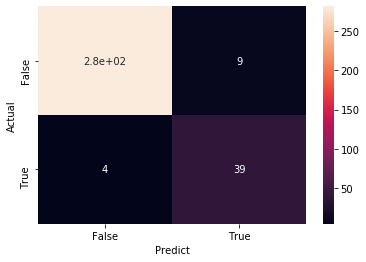

In [13]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

## Evaluation Metrics 확인

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
print("f1 metric: ", f1_score(df_churn_comp['y_actual'],df_churn_comp['y_predict'] ))
print("precision : ", precision_score(df_churn_comp['y_actual'],df_churn_comp['y_predict'] ))
print("recall_score : ", recall_score(df_churn_comp['y_actual'],df_churn_comp['y_predict'] ))
print("accuracy: ", accuracy_score(df_churn_comp['y_actual'],df_churn_comp['y_predict'] ))

f1 metric:  0.8571428571428572
precision :  0.8125
recall_score :  0.9069767441860465
accuracy:  0.9610778443113772


In [15]:
%store model_name

Stored 'model_name' (str)
